# Covariance estimation

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## Four-dimensional polynomial example $Y = X_1 + X_2^2 + X_3 X_4 + V$

### Data generation

In [3]:
# Number of samples
n_samples = 10**4

X = np.random.randn(n_samples, 4)
V = np.random.randn(n_samples)

# True model: Y = X1 + X2^2 + X3*X4 + V
Y = X[:, 0] + X[:, 1]**2 + X[:, 2]*X[:, 3] + V



# Compute the theoretical conditional expectation E[Y | X]
E_Y_given_X = X[:, 0] + X[:, 1]**2 + X[:, 2]*X[:, 3]

# Optional: Put everything in a DataFrame for easy inspection
df = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'X3': X[:, 2],
    'X4': X[:, 3],
    'V': V,
    'Y': Y,
    'E[Y|X]': E_Y_given_X
})

# Show the first few rows
print(df.head())

         X1        X2        X3        X4         V         Y    E[Y|X]
0  0.496714 -0.138264  0.647689  1.523030 -0.471858  1.030423  1.502280
1 -0.234153 -0.234137  1.579213  0.767435  1.012702  2.045312  1.032609
2 -0.469474  0.542560 -0.463418 -0.465730 -0.198187 -0.157462  0.040724
3  0.241962 -1.913280 -1.724918 -0.562288  0.090569  4.963073  4.872503
4 -1.012831  0.314247 -0.908024 -1.412304  0.717391  1.085717  0.368326


In [4]:
# # Build features and track labels
# features = [np.ones(n_samples)]
# feature_names = ["1"]  # intercept
# X_names = ["X1", "X2", "X3", "X4"]

# # Linear terms
# for i in range(4):
#     features.append(X[:, i])
#     feature_names.append(X_names[i])

# # Squared terms
# for i in range(4):
#     features.append(X[:, i] ** 2)
#     feature_names.append(f"{X_names[i]}^2")

# # Interaction terms
# for i, j in itertools.combinations(range(4), 2):
#     features.append(X[:, i] * X[:, j])
#     feature_names.append(f"{X_names[i]}*{X_names[j]}")

# # Stack into design matrix A
# A = np.column_stack(features)

# # Create DataFrame for inspection
# A_df = pd.DataFrame(A, columns=feature_names)

# # Preview
# print(A_df.head())


X_names = ["X1", "X2", "X3", "X4"]

# Build features and track labels (no intercept)
features = []
feature_names = []

# Linear terms
for i in range(4):
    features.append(X[:, i])
    feature_names.append(X_names[i])

# Squared terms
for i in range(4):
    features.append(X[:, i] ** 2)
    feature_names.append(f"{X_names[i]}^2")

# Interaction terms
for i, j in itertools.combinations(range(4), 2):
    features.append(X[:, i] * X[:, j])
    feature_names.append(f"{X_names[i]}*{X_names[j]}")

# Stack into design matrix A
A = np.column_stack(features)

# Create DataFrame for inspection
A_df = pd.DataFrame(A, columns=feature_names)

# Preview
print(A_df.head())

         X1        X2        X3  ...     X2*X3     X2*X4     X3*X4
0  0.496714 -0.138264  0.647689  ... -0.089552 -0.210581  0.986449
1 -0.234153 -0.234137  1.579213  ... -0.369752 -0.179685  1.211943
2 -0.469474  0.542560 -0.463418  ... -0.251432 -0.252686  0.215827
3  0.241962 -1.913280 -1.724918  ...  3.300251  1.075814  0.969900
4 -1.012831  0.314247 -0.908024  ... -0.285344 -0.443813  1.282406

[5 rows x 14 columns]


### LS using Cholesky

In [5]:
# Least squares solution using Cholesky
ATA = A.T @ A
ATy = A.T @ Y

# Compute condition number of A^T A (using 2-norm)
condition_number = np.linalg.cond(ATA)

print("Condition number of A^T A:", condition_number)

# Check if A^T A is positive definite
if np.all(np.linalg.eigvals(ATA) > 0):
    R = np.linalg.cholesky(ATA)
    z = np.linalg.solve(R.T, ATy)
    beta_hat = np.linalg.solve(R, z)
    print("Estimated coefficients β̂ using Cholesky:")
    print(beta_hat)
else:
    print("A^T A is not positive definite – fallback needed (e.g. SVD)")


Condition number of A^T A: 6.596412854000045
Estimated coefficients β̂ using Cholesky:
[ 0.98524846  0.04605256 -0.0155176  -0.02401356 -0.1548712   0.99500162
  0.10595344  0.17989396  0.0154222   0.01131537 -0.02685286 -0.00136024
  0.03423852  1.01098684]


### Compute $\bar{f}(X)$, $\hat{f}(X)$, $F_{\nu}^N$, $C_{\nu}^N$ and $D_{\nu}^N$

In [6]:

from sklearn.linear_model import LinearRegression
from IPython.display import display, Math

# Data generation
np.random.seed(42)
n_test = 10**5
X = np.random.randn(n_samples, 4)
V = np.random.randn(n_samples)

f_bar = X[:, 0] + X[:, 1]**2 + X[:, 2]*X[:, 3]
Y = f_bar + V

# Design matrix (no bias term)
features = []
for i in range(4):
    features.append(X[:, i])
for i in range(4):
    features.append(X[:, i] ** 2)
for i, j in itertools.combinations(range(4), 2):
    features.append(X[:, i] * X[:, j])
A = np.column_stack(features)


# Independent test set
n_test = 10**5
X_test = np.random.randn(n_test, 4)
V_test = np.random.randn(n_test)
f_bar_test = X_test[:, 0] + X_test[:, 1]**2 + X_test[:, 2]*X_test[:, 3]
Y_test = f_bar_test + V_test

# Test design matrix
features_test = []
for i in range(4):
    features_test.append(X_test[:, i])
for i in range(4):
    features_test.append(X_test[:, i] ** 2)
for i, j in itertools.combinations(range(4), 2):
    features_test.append(X_test[:, i] * X_test[:, j])
A_test = np.column_stack(features_test)

# OLS fit
ols = LinearRegression(fit_intercept=False)
ols.fit(A, Y)
f_hat = A_test @ ols.coef_

# === Monte Carlo metrics ===
Z = f_bar_test + np.random.randn(n_test)  # Independent copy of V

FN_nu = np.mean(Z * Y_test + f_hat * (f_hat - Y_test - Z))
CN_nu = np.mean(Y_test * Z)
DN_nu = np.mean(Y_test * (Y_test - Z))

norm_fhat_minus_fbar = np.sqrt(np.mean((f_hat - f_bar_test) ** 2))
norm_fbar = np.sqrt(np.mean(f_bar_test ** 2))
relative_L2_error = norm_fhat_minus_fbar / norm_fbar
sqrt_FN_over_CN = np.sqrt(abs(FN_nu) / CN_nu)
error_between_metrics = abs(relative_L2_error - sqrt_FN_over_CN)

# === Display results in LaTeX ===
display(Math(r"F_N^\nu = {:.6f}".format(FN_nu)))
display(Math(r"C_N^\nu = {:.6f}".format(CN_nu)))
display(Math(r"D_N^\nu = {:.6f}".format(DN_nu)))
display(Math(r"\left\| \hat{{f}} - \bar{{f}} \right\|_{{L^2(\nu)}} = {:.6f}".format(norm_fhat_minus_fbar)))
display(Math(r"\left\| \bar{{f}} \right\|_{{L^2(\nu)}} = {:.6f}".format(norm_fbar)))
display(Math(r"\text{{Relative }} L^2 \text{{ Error}} = {:.6f}".format(relative_L2_error)))
display(Math(r"\sqrt{{F_N^\nu / C_N^\nu}} = {:.6f}".format(sqrt_FN_over_CN)))
display(Math(r"\text{{Absolute Difference}} = {:.6f}".format(error_between_metrics)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
f_hat = A @ beta_hat
f_bar = X[:, 0] + X[:, 1]**2 + X[:, 2] * X[:, 3]
np.corrcoef(f_hat, f_bar)[0, 1]  # Should be close to 1

np.float64(0.9819047323558558)

## Estimation of $\mathbf{E}[\mathbf{Y}| \mathbf{X}]$ for multivariate Gaussian : $\mathbf{Y}|\mathbf{X} \sim \mathcal{N}(\boldsymbol{\mu}_{\mathbf{Y}|\mathbf{X}}, \mathbf{K}_{\mathbf{Y}|\mathbf{X}})$ 

In [8]:
# Define the mean vectors and covariance matrix
mu_X = np.array([1, 2])  # Mean of X
mu_Y = np.array([4, 3])  # Mean of Y

# Define the covariance matrix components
K_XX = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix for X
K_YY = np.array([[1, -0.5], [-0.5, 1]])  # Covariance matrix for Y
K_XY = np.array([[0.3, 0.2], [0.2, 0.3]])  # Covariance matrix between X and Y

# Construct the full covariance matrix Sigma
Sigma = np.block([
    [K_XX, K_XY],
    [K_XY.T, K_YY]
])

# Construct the joint mean vector mu
mu = np.concatenate([mu_X, mu_Y])

# Generate jointly Gaussian distributed samples
n_samples = 1000
samples = np.random.multivariate_normal(mu, Sigma, size=n_samples)

# Split the samples into X and Y
X_samples = samples[:, :2]
Y_samples = samples[:, 2:]

In [9]:
# Split the samples into X and Y
X_samples = samples[:, :2]
Y_samples = samples[:, 2:]
print(Y_samples.shape)

# Estimate conditional mean of Y given X using the formula
Sigma_XX_inv = np.linalg.inv(K_XX)
Sigma_XY = K_XY
# Perform element-wise subtraction for X_samples - mu_X, ensuring proper alignment
X_diff = X_samples - mu_X  # Shape will be (n_samples, 2)

# Compute conditional mean
mu_cond = mu_Y + X_diff @ Sigma_XX_inv @ Sigma_XY.T  # Shape (n_samples, 2) @ (2, 2) @ (2, 2) -> (n_samples, 2)
print(mu_cond.shape)

# Augment design matrix with bias term and cross-term X0*X1
X0_X1 = X_samples[:, 0] * X_samples[:, 1]  # Cross-term X0 * X1
A = np.column_stack([X_samples, X0_X1, np.ones(n_samples)])  # Add bias term (constant)

# Perform linear regression to estimate the conditional mean
ols = LinearRegression(fit_intercept=False)  # No intercept, because we added a bias term
ols.fit(A, Y_samples)
f_hat = A @ ols.coef_.T
print(f_hat.shape)

# Now compare mu_cond and f_hat
# Compute the absolute difference between the conditional expectation and the approximation
absolute_diff = np.mean(np.abs(mu_cond - f_hat))
print(absolute_diff)
norm_fhat_minus_fbar = np.sqrt(np.mean((f_hat - mu_cond) ** 2))
norm_fbar = np.sqrt(np.mean(mu_cond ** 2))
relative_L2_error = norm_fhat_minus_fbar / norm_fbar

# Display the results
display(Math(r"\left\| \hat{{f}} - \bar{{f}} \right\|_{{L^2(\nu)}} = {:.6f}".format(norm_fhat_minus_fbar)))
display(Math(r"\left\| \bar{{f}} \right\|_{{L^2(\nu)}} = {:.6f}".format(norm_fbar)))
display(Math(r"\text{{Relative }} L^2 \text{{ Error}} = {:.6f}".format(relative_L2_error)))

(1000, 2)
(1000, 2)
(1000, 2)
0.039321011376157754


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

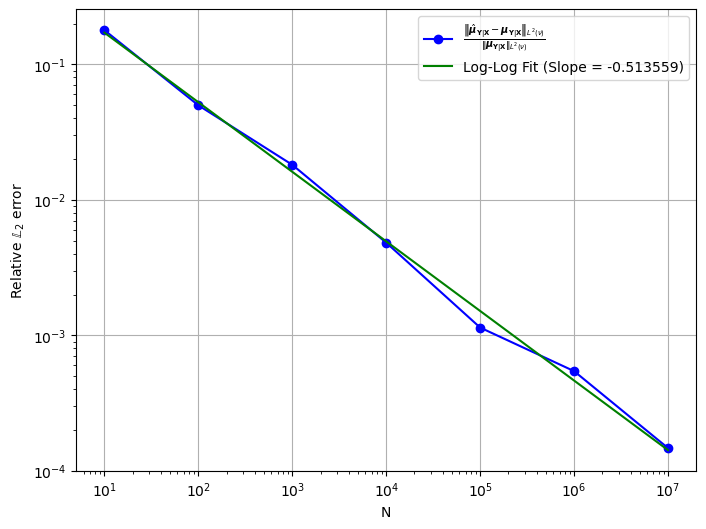

In [10]:
from sklearn.linear_model import LinearRegression

# Define parameters for X and Y
mu_X = np.array([1, 2])  # Mean of X
mu_Y = np.array([4, 3])  # Mean of Y
K_XX = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix for X
K_YY = np.array([[1, -0.5], [-0.5, 1]])  # Covariance matrix for Y
K_XY = np.array([[0.3, 0.2], [0.2, 0.3]])  # Covariance matrix between X and Y

# Define function to compute conditional mean mu_cond
def compute_conditional_mean(X, mu_X, mu_Y, Sigma_XX_inv, Sigma_XY):
    X_diff = X - mu_X  # Element-wise difference
    mu_cond = mu_Y + X_diff @ Sigma_XX_inv @ Sigma_XY.T  # Conditional mean
    return mu_cond

# Function to compute relative L2 error for a given sample size N
def compute_relative_L2_error(N):
    # Generate samples from the joint distribution
    mu = np.concatenate([mu_X, mu_Y])
    Sigma = np.block([
        [K_XX, K_XY],
        [K_XY.T, K_YY]
    ])
    samples = np.random.multivariate_normal(mu, Sigma, size=N)

    # Split the samples into X and Y
    X_samples = samples[:, :2]
    Y_samples = samples[:, 2:]

    # Compute the conditional mean mu_cond (true conditional mean)
    Sigma_XX_inv = np.linalg.inv(K_XX)
    Sigma_XY = K_XY
    mu_cond = compute_conditional_mean(X_samples, mu_X, mu_Y, Sigma_XX_inv, Sigma_XY)

    # Perform linear regression to estimate f_hat
    A = np.column_stack([X_samples, X_samples[:, 0] * X_samples[:, 1], np.ones(N)])
    ols = LinearRegression(fit_intercept=False)
    ols.fit(A, Y_samples)
    f_hat = A @ ols.coef_.T  # Predicted values of Y

    # Compute L2-norm of the difference (f_hat - mu_cond)
    norm_fhat_minus_fbar = np.sqrt(np.mean((f_hat - mu_cond) ** 2))

    # Compute L2-norm of the true conditional mean mu_cond
    norm_fbar = np.sqrt(np.mean(mu_cond ** 2))

    # Compute relative L2 error
    relative_L2_error = norm_fhat_minus_fbar / norm_fbar
    return relative_L2_error

# Values of N for which we will compute the relative L2 error
N_values = [10**i for i in range(1, 8)]
relative_L2_errors = [compute_relative_L2_error(N) for N in N_values]

# Log-log interpolation (linear regression in log-log space)
log_N_values = np.log(N_values)
log_relative_L2_errors = np.log(relative_L2_errors)

# Fit a linear model in the log-log space
model = LinearRegression()
model.fit(log_N_values.reshape(-1, 1), log_relative_L2_errors)

# Get the slope (coefficient) and intercept of the fit
slope = model.coef_[0]
intercept = model.intercept_

# Generate the interpolated log-log values for plotting
N_interp = np.logspace(np.log10(10), np.log10(10**7), num=100)
log_N_interp = np.log(N_interp)
log_interpolated_values = model.predict(log_N_interp.reshape(-1, 1))

# Plot the results on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(N_values, relative_L2_errors, marker='o', linestyle='-', color='b', label=r'$\frac{\left\| \hat{\boldsymbol{\mu}}_{\mathbf{Y}|\mathbf{X}} - \boldsymbol{\mu}_{\mathbf{Y}|\mathbf{X}} \right\|_{L^2(\nu)}}{\left\| \boldsymbol{\mu}_{\mathbf{Y}|\mathbf{X}} \right\|_{L^2(\nu)}}$')
plt.loglog(N_interp, np.exp(log_interpolated_values), linestyle='-', color='g', label=f'Log-Log Fit (Slope = {slope:.6f})')
plt.xlabel('N')
plt.ylabel(r'Relative $\mathbb{L}_2$ error')
plt.grid(True)
plt.legend()
plt.savefig('CondExpectL2errorGaussian.png', dpi=300, bbox_inches='tight')

plt.show()

## For 1D

In [4]:
import numpy as np
# Set random seed for reproducibility
np.random.seed(42)
from cond_expect_ols import compute_ols_parameters, compute_relative_L2_error

# Define parameters
num_samples = 100000
mu1 = 1
mu2 = 2
sigma1 = 5  # standard deviation of X
sigma2 = 10  # standard deviation of Y

X = np.random.normal(mu1, sigma1, num_samples)
Y = np.random.normal(mu2, sigma2, num_samples)

EYX, _, _ = compute_ols_parameters(X, Y)
mu_cond = 2
relerror = compute_relative_L2_error(EYX, mu_cond)
print(relerror)

0.03554848464563622
